# PNP

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [3]:
def treinar_e_roportar(models, X_train, y_train, X_test, y_test):
    for model in models:
        print(model)
        if(model == xgb_model):
            y_train = enc.transform(y_train.array.reshape(-1, 1))
            y_test = enc.transform(y_test.array.reshape(-1, 1))
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print('Acurácia teste: ', accuracy_score(y_test, preds)*100)
        print(classification_report(y_test, preds, digits=3))
        imprimeMatrizDeConfusão(y_test, preds, model)
        preds = model.predict(X_train)
        print('Acurácia treino: ', accuracy_score(y_train, preds)*100)
        print(classification_report(y_train, preds, digits=3))   

In [4]:
# Função do Bresolin

def metrics(curr_path, outdir, path_inference, cfgname, task, nclass, thr, proc):
    '''
    Get all metrics and save in text file
    '''    
    pred = pd.read_table(os.path.join(curr_path, outdir, path_inference, cfgname.replace('.cfg', '.pred')), header = None, sep = ' ').to_numpy()
    if task == 'class':
        y_obs = pred[:,0].astype(int)
        y_pred = (pred[:,1] > thr).astype('int')
        cm_mat = confusion_matrix(y_obs, y_pred)
       
        if cm_mat.shape[0] != cm_mat.shape[1]:
            sys.exit('Error: Number of true and predicted classes are different.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')
        elif cm_mat.shape[0] == 1:
            sys.exit('Error: Number of true classes are equal 1.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')
        elif cm_mat.shape[1] == 1:
            sys.exit('Error: Number of predicted classes are equal 1.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')  
        metrics = []
       
        if nclass == 2:
            tp = cm_mat[1,1]
            tn = cm_mat[0,0]
            fp = cm_mat[0,1]
            fn = cm_mat[1,0]
            acc = round(((tp + tn) / (tp + tn + fp + fn)), 2) * 100
            err = 100 - acc
            sen = round((tp / (tp + fn)), 2) * 100
            spe = round((tn / (tn + fp)), 2) * 100
            ppv = round((tp / (tp + fp)), 2) * 100
            npv = round((tn / (tn + fn)), 2) * 100
            metrics = pd.DataFrame(data = {'ACC': [acc], 'ERR': [err], 'SEN': [sen],
                                           'SPE': [spe], 'PPV': [ppv], 'NPV': [npv]})
        # else: for more than 2 two classes
    else:
        stats = np.load(os.path.join(curr_path, outdir, 'data/train/stats.npy'), mmap_mode = 'r')
        pred = backTransform(pred, stats, proc)
        x = pred[:,1]
        y = pred[:,0]
        mse = (1/ len(x)) * np.sum((y - x)**2)
        rmse = mt.sqrt(mse)
       
        x = x.reshape((-1, 1))
        model = LinearRegression().fit(x, y)
        r2 = model.score(x, y)
        slope = model.coef_[0]
        metrics = pd.DataFrame(data = {'R2': [r2], 'Slope': [slope], 'MSE': [mse], 'RMSE': [rmse]})
    metrics.to_csv(os.path.join(curr_path, outdir, path_inference, cfgname.replace('.cfg','.stat')), sep = ' ', header = True, mode = 'w', decimal = '.', index = False)

## Leave One Group Out

In [5]:
from sklearn.model_selection import LeaveOneGroupOut
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [6]:
# Modelos PNP
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=88, subsample=0.729, 
                           colsample_bytree=0.671, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)

rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=50,
                                  criterion='entropy', min_samples_split=30, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1)

knn_model = KNeighborsClassifier(n_neighbors=46, weights='distance', leaf_size=20, p=2, n_jobs=-1)

xgb_model = XGBClassifier(learning_rate=0.008851671496973969, max_depth=16,
                          min_child_weight=1, gamma=0.0, colsample_bytree=0.631278076735511, use_label_encoder=False, random_state=0, n_jobs=-1)

rn_model = MLPClassifier(hidden_layer_sizes=(20,30,30,20), activation="tanh", random_state=0)

models = [lgb_model, rf_model, knn_model, rn_model, xgb_model]

In [7]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [8]:
df = pd.read_csv(caminho_dados_lazaro)

In [9]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

In [10]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [11]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
df = df.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')

In [12]:
y = df.Comportamento
X = df[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]

enc = OrdinalEncoder()
enc.fit(y.array.reshape(-1, 1))

OrdinalEncoder()

In [13]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_season = X[['Season_fall', 'Season_spring', 'Season_summer']]

X = X.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)

columns = X.columns
index= X.index

sc = StandardScaler()
X = sc.fit_transform(X)

X = pd.DataFrame(X, columns=columns, index=index)

X = pd.concat([X, X_season], axis=1)

#### Leave Fall Out

In [17]:
df[df.Season_spring == 1].shape

(139668, 20)

In [22]:
df[df.Season_spring == 1].Comportamento.value_counts()

Não Pastejando    74329
Pastejando        65339
Name: Comportamento, dtype: int64

In [18]:
df[df.Season_summer == 1].shape

(221119, 20)

In [23]:
df[df.Season_summer == 1].Comportamento.value_counts()

Pastejando        120544
Não Pastejando    100575
Name: Comportamento, dtype: int64

In [19]:
df[df.Season_fall == 1].shape

(246363, 20)

In [24]:
df[df.Season_fall == 1].Comportamento.value_counts()

Pastejando        146629
Não Pastejando     99734
Name: Comportamento, dtype: int64

In [61]:
df_test = df[df.Season_fall == 1]

In [62]:
df_train = df[df.Season_fall == 0]

In [63]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento

LGBMClassifier(colsample_bytree=0.671, min_child_samples=88, num_leaves=512,
               random_state=0, subsample=0.729, subsample_freq=1)
Acurácia teste:  67.94689137573418
                precision    recall  f1-score   support

Não Pastejando      0.652     0.447     0.530     99734
    Pastejando      0.690     0.837     0.757    146629

      accuracy                          0.679    246363
     macro avg      0.671     0.642     0.644    246363
  weighted avg      0.675     0.679     0.665    246363



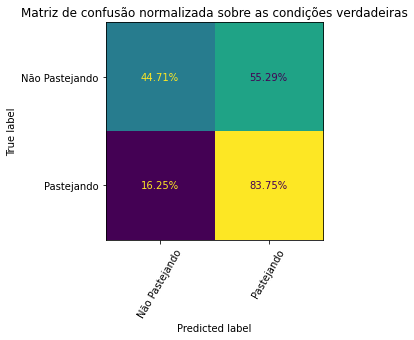

Acurácia treino:  80.56720447244497
                precision    recall  f1-score   support

Não Pastejando      0.824     0.762     0.792    174904
    Pastejando      0.791     0.847     0.818    185883

      accuracy                          0.806    360787
     macro avg      0.807     0.804     0.805    360787
  weighted avg      0.807     0.806     0.805    360787

RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       min_samples_split=30, n_estimators=200, n_jobs=-1,
                       random_state=0)
Acurácia teste:  67.25847631340746
                precision    recall  f1-score   support

Não Pastejando      0.613     0.519     0.562     99734
    Pastejando      0.704     0.777     0.739    146629

      accuracy                          0.673    246363
     macro avg      0.658     0.648     0.650    246363
  weighted avg      0.667     0.673     0.667    246363



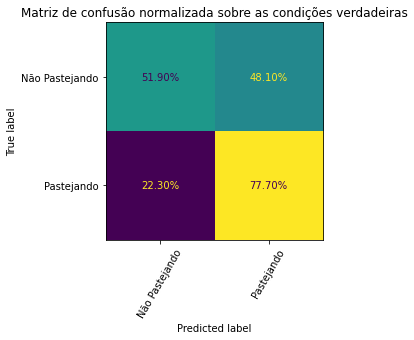

Acurácia treino:  87.29499677094795
                precision    recall  f1-score   support

Não Pastejando      0.893     0.839     0.865    174904
    Pastejando      0.857     0.905     0.880    185883

      accuracy                          0.873    360787
     macro avg      0.875     0.872     0.872    360787
  weighted avg      0.874     0.873     0.873    360787

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=46,
                     weights='distance')
Acurácia teste:  58.75679383673684
                precision    recall  f1-score   support

Não Pastejando      0.488     0.369     0.420     99734
    Pastejando      0.632     0.736     0.680    146629

      accuracy                          0.588    246363
     macro avg      0.560     0.553     0.550    246363
  weighted avg      0.573     0.588     0.575    246363



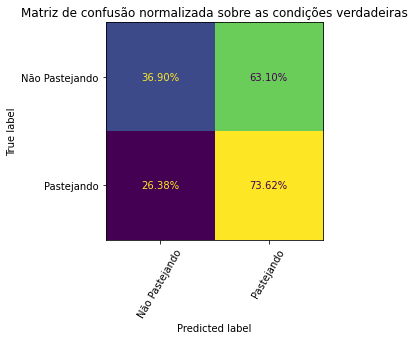

Acurácia treino:  99.99113050082181
                precision    recall  f1-score   support

Não Pastejando      1.000     1.000     1.000    174904
    Pastejando      1.000     1.000     1.000    185883

      accuracy                          1.000    360787
     macro avg      1.000     1.000     1.000    360787
  weighted avg      1.000     1.000     1.000    360787

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              random_state=0)


/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Acurácia teste:  61.70610034786068
                precision    recall  f1-score   support

Não Pastejando      0.586     0.183     0.279     99734
    Pastejando      0.621     0.912     0.739    146629

      accuracy                          0.617    246363
     macro avg      0.604     0.548     0.509    246363
  weighted avg      0.607     0.617     0.553    246363



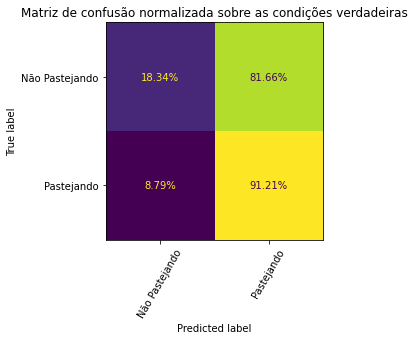

Acurácia treino:  75.44007960375512
                precision    recall  f1-score   support

Não Pastejando      0.767     0.709     0.737    174904
    Pastejando      0.744     0.797     0.770    185883

      accuracy                          0.754    360787
     macro avg      0.756     0.753     0.753    360787
  weighted avg      0.755     0.754     0.754    360787

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.631278076735511,
              enable_categorical=False, gamma=0.0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.008851671496973969, max_delta_step=None,
              max_depth=16, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=0,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
           

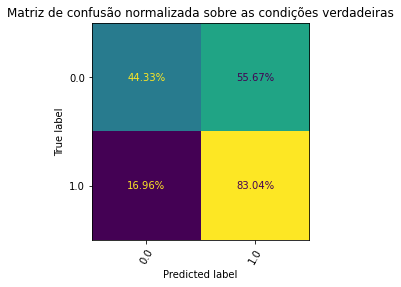

Acurácia treino:  86.1472281429209
              precision    recall  f1-score   support

         0.0      0.883     0.823     0.852    174904
         1.0      0.844     0.898     0.870    185883

    accuracy                          0.861    360787
   macro avg      0.863     0.860     0.861    360787
weighted avg      0.863     0.861     0.861    360787



In [64]:
treinar_e_roportar(models, X_train, y_train, X_test, y_test)   

#### Leave Height Out 10 cm

In [65]:
df_test = df[df['Altura esperada'] == 10.0]

In [66]:
df_train = df[df['Altura esperada'] != 10.0]

In [67]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento

LGBMClassifier(colsample_bytree=0.671, min_child_samples=88, num_leaves=512,
               random_state=0, subsample=0.729, subsample_freq=1)
Acurácia teste:  60.074649531921786
                precision    recall  f1-score   support

Não Pastejando      0.580     0.329     0.420     65083
    Pastejando      0.608     0.813     0.696     83076

      accuracy                          0.601    148159
     macro avg      0.594     0.571     0.558    148159
  weighted avg      0.596     0.601     0.575    148159



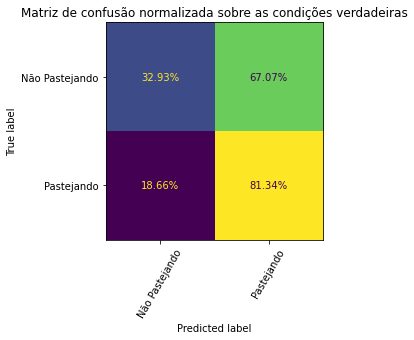

Acurácia treino:  83.54477538775271
                precision    recall  f1-score   support

Não Pastejando      0.840     0.790     0.814    209555
    Pastejando      0.832     0.874     0.852    249436

      accuracy                          0.835    458991
     macro avg      0.836     0.832     0.833    458991
  weighted avg      0.836     0.835     0.835    458991

RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       min_samples_split=30, n_estimators=200, n_jobs=-1,
                       random_state=0)
Acurácia teste:  60.183316572061095
                precision    recall  f1-score   support

Não Pastejando      0.587     0.317     0.411     65083
    Pastejando      0.607     0.825     0.699     83076

      accuracy                          0.602    148159
     macro avg      0.597     0.571     0.555    148159
  weighted avg      0.598     0.602     0.573    148159



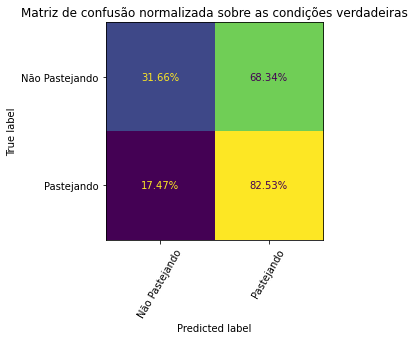

Acurácia treino:  88.39824746018985
                precision    recall  f1-score   support

Não Pastejando      0.897     0.843     0.869    209555
    Pastejando      0.874     0.918     0.896    249436

      accuracy                          0.884    458991
     macro avg      0.886     0.881     0.882    458991
  weighted avg      0.885     0.884     0.884    458991

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=46,
                     weights='distance')
Acurácia teste:  56.08434182196154
                precision    recall  f1-score   support

Não Pastejando      0.500     0.407     0.449     65083
    Pastejando      0.595     0.681     0.635     83076

      accuracy                          0.561    148159
     macro avg      0.547     0.544     0.542    148159
  weighted avg      0.553     0.561     0.553    148159



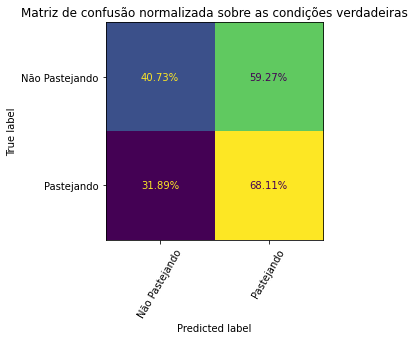

Acurácia treino:  99.99259244734647
                precision    recall  f1-score   support

Não Pastejando      1.000     1.000     1.000    209555
    Pastejando      1.000     1.000     1.000    249436

      accuracy                          1.000    458991
     macro avg      1.000     1.000     1.000    458991
  weighted avg      1.000     1.000     1.000    458991

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              random_state=0)
Acurácia teste:  57.52603621784704
                precision    recall  f1-score   support

Não Pastejando      0.526     0.332     0.407     65083
    Pastejando      0.594     0.766     0.669     83076

      accuracy                          0.575    148159
     macro avg      0.560     0.549     0.538    148159
  weighted avg      0.564     0.575     0.554    148159



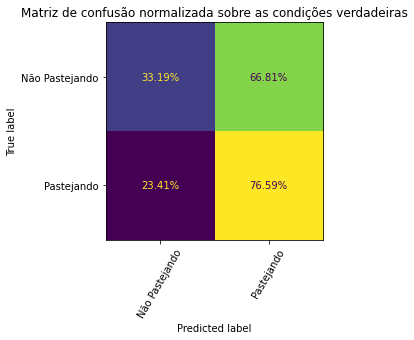

Acurácia treino:  79.3793342353118
                precision    recall  f1-score   support

Não Pastejando      0.790     0.746     0.768    209555
    Pastejando      0.796     0.834     0.815    249436

      accuracy                          0.794    458991
     macro avg      0.793     0.790     0.791    458991
  weighted avg      0.794     0.794     0.793    458991

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.631278076735511,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.008851671496973969, max_delta_step=0,
              max_depth=16, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_

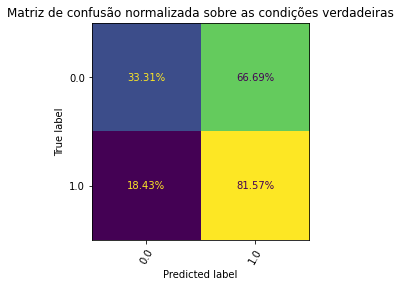

Acurácia treino:  87.51151983372223
              precision    recall  f1-score   support

         0.0      0.884     0.836     0.859    209555
         1.0      0.868     0.908     0.888    249436

    accuracy                          0.875    458991
   macro avg      0.876     0.872     0.874    458991
weighted avg      0.876     0.875     0.875    458991



In [68]:
treinar_e_roportar(models, X_train, y_train, X_test, y_test) 

#### Leave Animals Out

In [69]:
df.Animal.value_counts()

95     119449
81     113724
84     110268
93      98043
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [70]:
df_test = df.loc[df['Animal'].isin([84, 93])]

In [71]:
df_test.Animal.value_counts()

84    110268
93     98043
Name: Animal, dtype: int64

In [72]:
df_train = df.loc[~df['Animal'].isin([84, 93])]

In [73]:
df_train.Animal.value_counts()

95     119449
81     113724
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [74]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento

LGBMClassifier(colsample_bytree=0.671, min_child_samples=88, num_leaves=512,
               random_state=0, subsample=0.729, subsample_freq=1)
Acurácia teste:  60.402955196797095
                precision    recall  f1-score   support

Não Pastejando      0.598     0.377     0.463     94114
    Pastejando      0.606     0.791     0.686    114197

      accuracy                          0.604    208311
     macro avg      0.602     0.584     0.575    208311
  weighted avg      0.603     0.604     0.585    208311



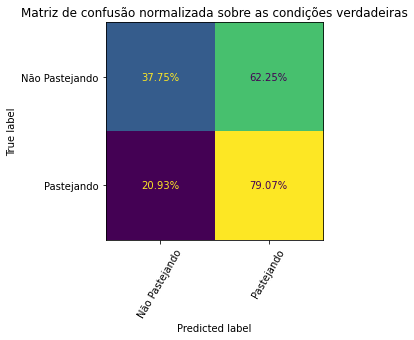

Acurácia treino:  83.3424013198308
                precision    recall  f1-score   support

Não Pastejando      0.844     0.775     0.808    180524
    Pastejando      0.826     0.882     0.853    218315

      accuracy                          0.833    398839
     macro avg      0.835     0.828     0.830    398839
  weighted avg      0.834     0.833     0.833    398839

RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       min_samples_split=30, n_estimators=200, n_jobs=-1,
                       random_state=0)
Acurácia teste:  59.38860645861236
                precision    recall  f1-score   support

Não Pastejando      0.584     0.353     0.440     94114
    Pastejando      0.598     0.793     0.682    114197

      accuracy                          0.594    208311
     macro avg      0.591     0.573     0.561    208311
  weighted avg      0.591     0.594     0.572    208311



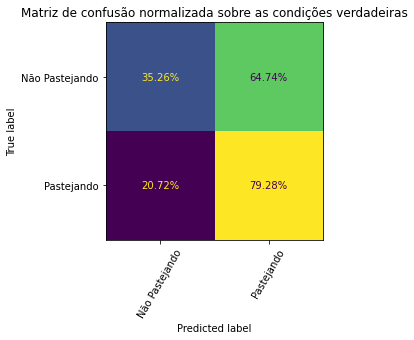

Acurácia treino:  88.54801060076873
                precision    recall  f1-score   support

Não Pastejando      0.902     0.838     0.869    180524
    Pastejando      0.874     0.924     0.898    218315

      accuracy                          0.885    398839
     macro avg      0.888     0.881     0.884    398839
  weighted avg      0.886     0.885     0.885    398839

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=46,
                     weights='distance')
Acurácia teste:  56.888018395572004
                precision    recall  f1-score   support

Não Pastejando      0.531     0.387     0.448     94114
    Pastejando      0.587     0.719     0.646    114197

      accuracy                          0.569    208311
     macro avg      0.559     0.553     0.547    208311
  weighted avg      0.562     0.569     0.557    208311



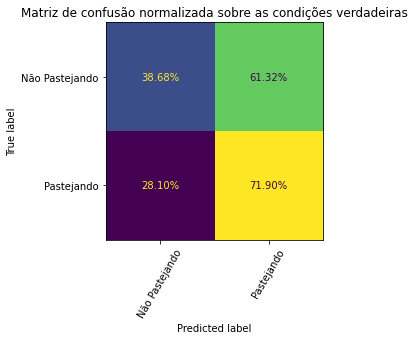

Acurácia treino:  99.99423326204308
                precision    recall  f1-score   support

Não Pastejando      1.000     1.000     1.000    180524
    Pastejando      1.000     1.000     1.000    218315

      accuracy                          1.000    398839
     macro avg      1.000     1.000     1.000    398839
  weighted avg      1.000     1.000     1.000    398839

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              random_state=0)
Acurácia teste:  58.46930790980793
                precision    recall  f1-score   support

Não Pastejando      0.566     0.348     0.431     94114
    Pastejando      0.592     0.780     0.673    114197

      accuracy                          0.585    208311
     macro avg      0.579     0.564     0.552    208311
  weighted avg      0.580     0.585     0.564    208311



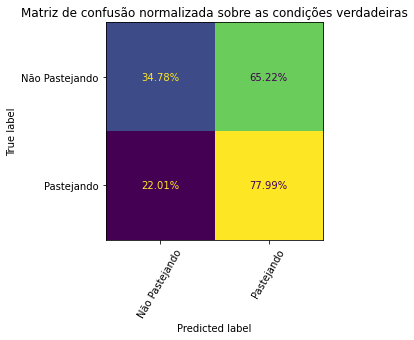

Acurácia treino:  78.06107226224115
                precision    recall  f1-score   support

Não Pastejando      0.785     0.710     0.746    180524
    Pastejando      0.778     0.839     0.807    218315

      accuracy                          0.781    398839
     macro avg      0.781     0.775     0.776    398839
  weighted avg      0.781     0.781     0.779    398839

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.631278076735511,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.008851671496973969, max_delta_step=0,
              max_depth=16, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree

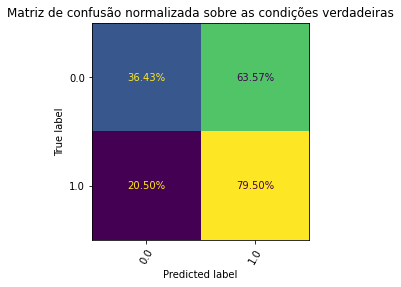

Acurácia treino:  88.20351068977708
              precision    recall  f1-score   support

         0.0      0.898     0.834     0.865    180524
         1.0      0.870     0.922     0.895    218315

    accuracy                          0.882    398839
   macro avg      0.884     0.878     0.880    398839
weighted avg      0.883     0.882     0.882    398839



In [75]:
treinar_e_roportar(models, X_train, y_train, X_test, y_test)